In [1]:
# Standard modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import validation_curve, ShuffleSplit
from sklearn.metrics import explained_variance_score, make_scorer
from sklearn.svm import SVR

# Custom modules
from jpm_time_conversions import *

__author__ = 'James Paul Mason'
__contact__ = 'jmason86@gmail.com'


def automatic_fit_coronal_dimming_light_curve(light_curve_df, minimum_score=0.3, plots_save_path=None, verbose=False):
    """Automatically fit the best support vector machine regression (SVR) model for the input light curve.

    Inputs:
        light_curve_df [pd DataFrame]: A pandas DataFrame with a DatetimeIndex, and columns for intensity and uncertainty.

    Optional Inputs:
        minimum_score [float]: Set this to the minimum explained variance score (0 - 1) acceptable for fits. If the 
                               best fit score is < minimum_score, this function will return None. Default value is 0.3.
        plots_save_path [str]: Set to a path in order to save the validation curve and best fit overplot on the data to disk.
                               Default is None, meaning no plots will be saved to disk.
        verbose [bool]:        Set to print out the processing messages. Default is False.

    Outputs:
        light_curve_fit [pd DataFrame]: A pandas DataFrame with a DatetimeIndex, and columns for fitted intensity and uncertainty.
        best_fit_gamma [float]:         The best found gamma hyper parameter for the SVR. 
        best_fit_score [float]:         The best explained variance score. 

    Optional Outputs:
        None

    Example:
        light_curve_fit, best_fit_gamma, best_fit_score = automatic_fit_coronal_dimming_light_curve(light_curve_df, verbose=True)
    """
    return 1

/Users/jmason86/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/style/core.py:197: UserWarning: In /Users/jmason86/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/jpm-dark.mplstyle: Bad val "'tight'" on line #17
	"savefig.bbox: 'tight'
"
	in file "/Users/jmason86/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/jpm-dark.mplstyle"
	Key savefig.bbox: bbox should be 'tight' or 'standard'
  warnings.warn(message)

Bad key "figure.tight_layout" on line 17 in
/Users/jmason86/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/jpm-light.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution

Bad key "plt.tight_layout" on line 18 in
/Users/jmason86/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/jpm-light.mplstyle.
You probably need to get an updated

In [2]:
# prototype only: load some example dimming light curve data
minimum_score = 0.3
plots_save_path='./'
verbose = 1
from scipy.io.idl import readsav
idl_generated_data = readsav('/Users/jmason86/Dropbox/Research/Postdoc_NASA/Analysis/Coronal Dimming Analysis/Example Dimming Light Curve.sav')
from calculate_eve_fe_line_precision import calculate_eve_fe_line_precision
uncertainty = calculate_eve_fe_line_precision()[3] * 100. + np.zeros(len(idl_generated_data.yyyydoy)) # * 100 for [%]
light_curve_df = pd.DataFrame({'irradiance': idl_generated_data.irradiance[:, 3],
                               'uncertainty': uncertainty})
light_curve_df.index = yyyydoy_sod_to_datetime(idl_generated_data.yyyydoy, idl_generated_data.sod) # Convert EVE to datetime
light_curve_df.head()

,irradiance,uncertainty
2012-04-15 17:43:20,0.246831,0.160099
2012-04-15 17:43:25,0.399922,0.160099
2012-04-15 17:43:30,0.275836,0.160099
2012-04-15 17:43:35,0.319487,0.160099
2012-04-15 17:43:40,0.920058,0.160099


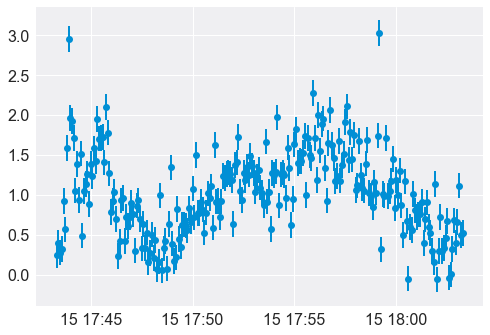

In [3]:
# prototype only: just taking a look at the data
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('jpm-light')
plt.errorbar(light_curve_df.index, light_curve_df['irradiance'], yerr=light_curve_df['uncertainty'], fmt='o');

In [4]:
# Pull data out of the DataFrame for compatibility formatting
X = metatimes_to_seconds_since_start(light_curve_df.index)
y = light_curve_df['irradiance'].values

# Check for NaNs and issue warning that they are being removed from the dataset
if verbose:
    if np.isnan(y).any():
        print("automatic_fit_coronal_dimming_light_curve: Warning: There are NaN values in light curve. Dropping them.")
        # TODO: Also print to log?
X = X[np.isfinite(y)]
X = X.reshape(len(X), 1) # Format to be compatible with validation_curve and SVR.fit()
uncertainty = uncertainty[np.isfinite(y)]
y = y[np.isfinite(y)]

if verbose:
    print("automatic_fit_coronal_dimming_light_curve: Fitting %s points." % len(y))

automatic_fit_coronal_dimming_light_curve: Warning: There are NaN values in light curve. Dropping them.
automatic_fit_coronal_dimming_light_curve: Fitting 240 points.


In [5]:
# Helper function for compatibility with validation_curve
def jpm_svr(gamma=1e-6, **kwargs):
    return make_pipeline(SVR(kernel='rbf', C=1e3, gamma=gamma, **kwargs))

In [6]:
# Hyper parameter for SVR is gamma, so generate values of it to try
gamma = np.logspace(-7, 1, num=20, base=10)

# Overwrite the default scorer (R^2) with explained variance score
evs = make_scorer(explained_variance_score)

# Split the data between training/testing 50/50 but across the whole time range rather than the default consecutive Kfolds
shuffle_split = ShuffleSplit(n_splits=150, train_size=0.5, test_size=0.5, random_state=None)

# Generate the validation curve -- test all them gammas!
# Parallelized to speed it up (n_jobs = # of parallel threads)
train_score, val_score = validation_curve(jpm_svr(), X, y,
                                          'svr__gamma',
                                          gamma, cv=shuffle_split, n_jobs=7, scoring=evs)

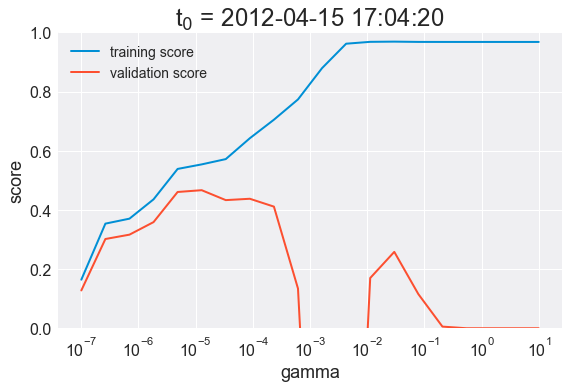

In [11]:
if plots_save_path:
    plt.plot(gamma, np.median(train_score, 1), label='training score')
    plt.plot(gamma, np.median(val_score, 1), label='validation score')
    ax = plt.axes()
    plt.legend(loc='best')
    plt.title("t$_0$ = " + datetimeindex_to_human(light_curve_df.index)[0])
    ax.set_xscale('log')
    plt.xlabel('gamma')
    plt.ylabel('score')
    plt.ylim(0, 1)
    plt.tight_layout();
    plt.savefig('Validation Curve t0 ' + datetimeindex_to_human(light_curve_df.index)[0] + '.png')

In [8]:
scores = np.median(val_score, axis=1)
best_fit_score = np.max(scores)
best_fit_gamma = gamma[np.argmax(scores)]
print('Scores: ', scores)
print('Best score:', best_fit_score)
print('Best fit gamma: ', best_fit_gamma)

Scores:  [  1.27810564e-01   3.01661406e-01   3.16348948e-01   3.58767340e-01
   4.60605617e-01   4.66643015e-01   4.33093213e-01   4.37680385e-01
   4.11129894e-01   1.34184398e-01  -1.41822275e+00  -1.48142467e+00
   1.69788071e-01   2.58177577e-01   1.15383557e-01   5.53401565e-03
   1.17357780e-06   2.22044605e-16   0.00000000e+00   0.00000000e+00]
Best score: 0.466643015037
Best fit gamma:  1.2742749857e-05


In [9]:
X_fit = np.linspace(0, X[-1], 50)[:, None]
X_fit = X_fit.reshape(len(X_fit), 1)
sample_weight = 1 / uncertainty
model = SVR(kernel='rbf', C=1e3, gamma=gamma[np.argmax(score)]).fit(X, y, sample_weight)
y_fit = model.predict(X_fit)
plt.errorbar(X.ravel(), y, yerr=uncertainty, color='black', fmt='o')
plt.plot(X_fit.ravel(), y_test, linewidth=6)
plt.xlabel('time [seconds since start]')
plt.ylabel('irradiance [%]');

NameError: name 'score' is not defined

In [ ]:
# Returns
light_curve_fit = y_test

best_fit_gamma = best_fit_gamma, best_fit_score